# Heat Flux from Propellant (Open Burn, Top Down)

This notebook treats the heat flux and its estimation based on open burning of propellant in drums or in fires. NOT TREATED HERE are the results from a bottom ignition or an explosion where the burn varies significantly from a somewhat stead state top down or perimeter to center of a collection of propellant. Or in other words, explosions are not treated hear or where the propellant is ejected up into the air and subsequently rapidly burns. Clint Guymon, Safety Management Services, Inc.

## Necessary code and data import

In [1]:
#Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea

### Import data

The majority of the heat flux data is from "Scaling Studies of Thermal Radiation Flux from Burning Propellants" by J. Hay and R.W. Watson of Bureau of Mines as commissioned by the DDESB in 1992. Various propellant types and masses were tested in a top down burn or external fire of a single barrel or package of propellant.

In [2]:
df = pd.read_csv('jupyterfiles/heatfluxdata.csv')

### Data summary

In [3]:
#propellant types
set(df['Propellant type'])

{'IMR5010', 'M1-8-MP', 'M1-8-SP', 'WC844', 'WC846', 'WCBlank'}

In [4]:
#number of tests for each propellant
df.groupby('Propellant type')['Test #'].nunique()

Propellant type
IMR5010    13
M1-8-MP    12
M1-8-SP    14
WC844       4
WC846       3
WCBlank     3
Name: Test #, dtype: int64

In [5]:
len(df)

206

In [6]:
df.describe() #summary statistics for numerical data

,Test #,"Mass, kg","Distance, m","Peak heat flux, cal/cm2/sec","Average heat flux, cal/cm2/sec","Burn time, sec","total heat radiated, Mcal","Drum diameter, cm"
count,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,150.0
mean,21.058252,90.733981,10.110680,0.547471,0.234621,31.186893,48.787864,60.0
std,13.152260,74.939888,5.299248,0.654004,0.255557,33.598392,47.114423,0.0
min,1.000000,45.400000,2.500000,0.027000,0.009000,8.000000,8.000000,60.0
25%,10.250000,47.600000,5.000000,0.159500,0.072000,15.000000,19.822500,60.0
50%,20.000000,49.900000,9.000000,0.350000,0.145000,21.900000,28.600000,60.0
75%,30.000000,99.800000,15.000000,0.650000,0.289750,30.900000,68.175000,60.0
max,49.000000,399.200000,20.000000,5.800000,1.393000,215.000000,229.200000,60.0


In [7]:
df.head(5) #first 5 rows of the data frame

,Reference,Propellant type,Test #,"Mass, kg","Distance, m","Peak heat flux, cal/cm2/sec","Average heat flux, cal/cm2/sec","Burn time, sec","total heat radiated, Mcal",Notes,"Drum diameter, cm"
0,"DDESB, BOM, SCALING STUDIES OF THERMAL RADIATI...",IMR5010,1,45.4,3.2,1.750,0.482,35.0,13.8,Barrel,60.0
1,"DDESB, BOM, SCALING STUDIES OF THERMAL RADIATI...",IMR5010,1,45.4,4.0,1.050,0.329,35.0,13.8,Barrel,60.0
2,"DDESB, BOM, SCALING STUDIES OF THERMAL RADIATI...",IMR5010,1,45.4,5.0,1.068,0.289,35.0,13.8,Barrel,60.0
3,"DDESB, BOM, SCALING STUDIES OF THERMAL RADIATI...",IMR5010,1,45.4,6.4,0.576,0.161,35.0,13.8,Barrel,60.0
4,"DDESB, BOM, SCALING STUDIES OF THERMAL RADIATI...",IMR5010,1,45.4,8.0,0.468,0.127,35.0,13.8,Barrel,60.0


### Calculate the Safe distance

Calculate the safe distance based on the average heat flux observed in all of the tests to determine the parameters of the Point Source Model:
\begin{align}
q = \frac{\alpha}{r^2}
\end{align}

After determining the array of alphas for each test (based on the average heat flux), caluclate the distance that yields a heat flux of 0.3 cal/cm2/sec which is the cutoff per DOD 6055 and 4145 per sections C4.4.5 and C5.7.1.3, respectively. The average heat flux is used as the peak heat flux values are typically more than twice the value of the average and represent a short term event typically.

In [8]:
pso = 2 #normal point source drops off to the second power
hfm = 0.3 #cal/cm2/s max heat flux for safe exposure

In [9]:
safeDistance = df.groupby('Test #').apply(lambda x: (np.percentile(x['Average heat flux, cal/cm2/sec']*
                                                      4*np.pi*x['Distance, m']**pso,75)/hfm/(4*np.pi))**(1/pso))

In [10]:
df['Safe distance, m'] = np.array(df.groupby('Test #').apply(lambda x: safeDistance.loc[x['Test #']]))

### Calculate the Safe distance versus Burn time factors by mass

One of the best correlations from the open burn data of multiple different proellants is the relationship between the burn time and safe distance by mass.  The below code calculates the factors relating the safe distance and burn time per mass bin according to:
\begin{align}
\text{Safe distance} = \frac{\text{factor}(\text{mass})}{{\text{burn time}}^{0.5}} 
\end{align}
The plot showing the use of the factor is below.

In [11]:
bins = np.array([20, 70, 160, 280, 500])
df['Mass bin, kg'] = pd.cut(df['Mass, kg'], bins)

In [12]:
factor = df.groupby('Mass bin, kg').apply(lambda x: (np.percentile(x['Safe distance, m']*x['Burn time, sec']**0.5,75)))

## Summary plots

In [13]:
sea.set_palette(sea.color_palette("Paired"))

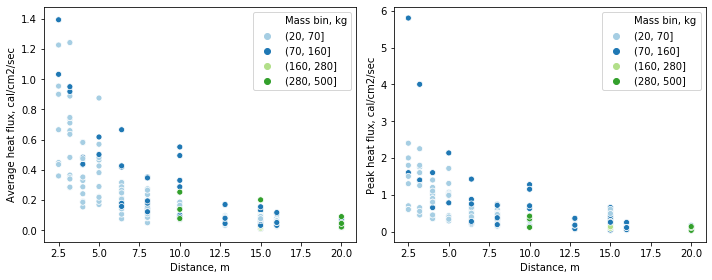

In [14]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
sea.scatterplot(df['Distance, m'],df['Average heat flux, cal/cm2/sec'],hue=df['Mass bin, kg'],ax=ax[0])
sea.scatterplot(df['Distance, m'],df['Peak heat flux, cal/cm2/sec'],hue=df['Mass bin, kg'],ax=ax[1])
plt.tight_layout()
plt.show()

In [15]:
dfsub = df.drop(['Test #','Drum diameter, cm','Reference','Notes'],axis=1) #remove columns with strings

C:\Users\cguymon\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


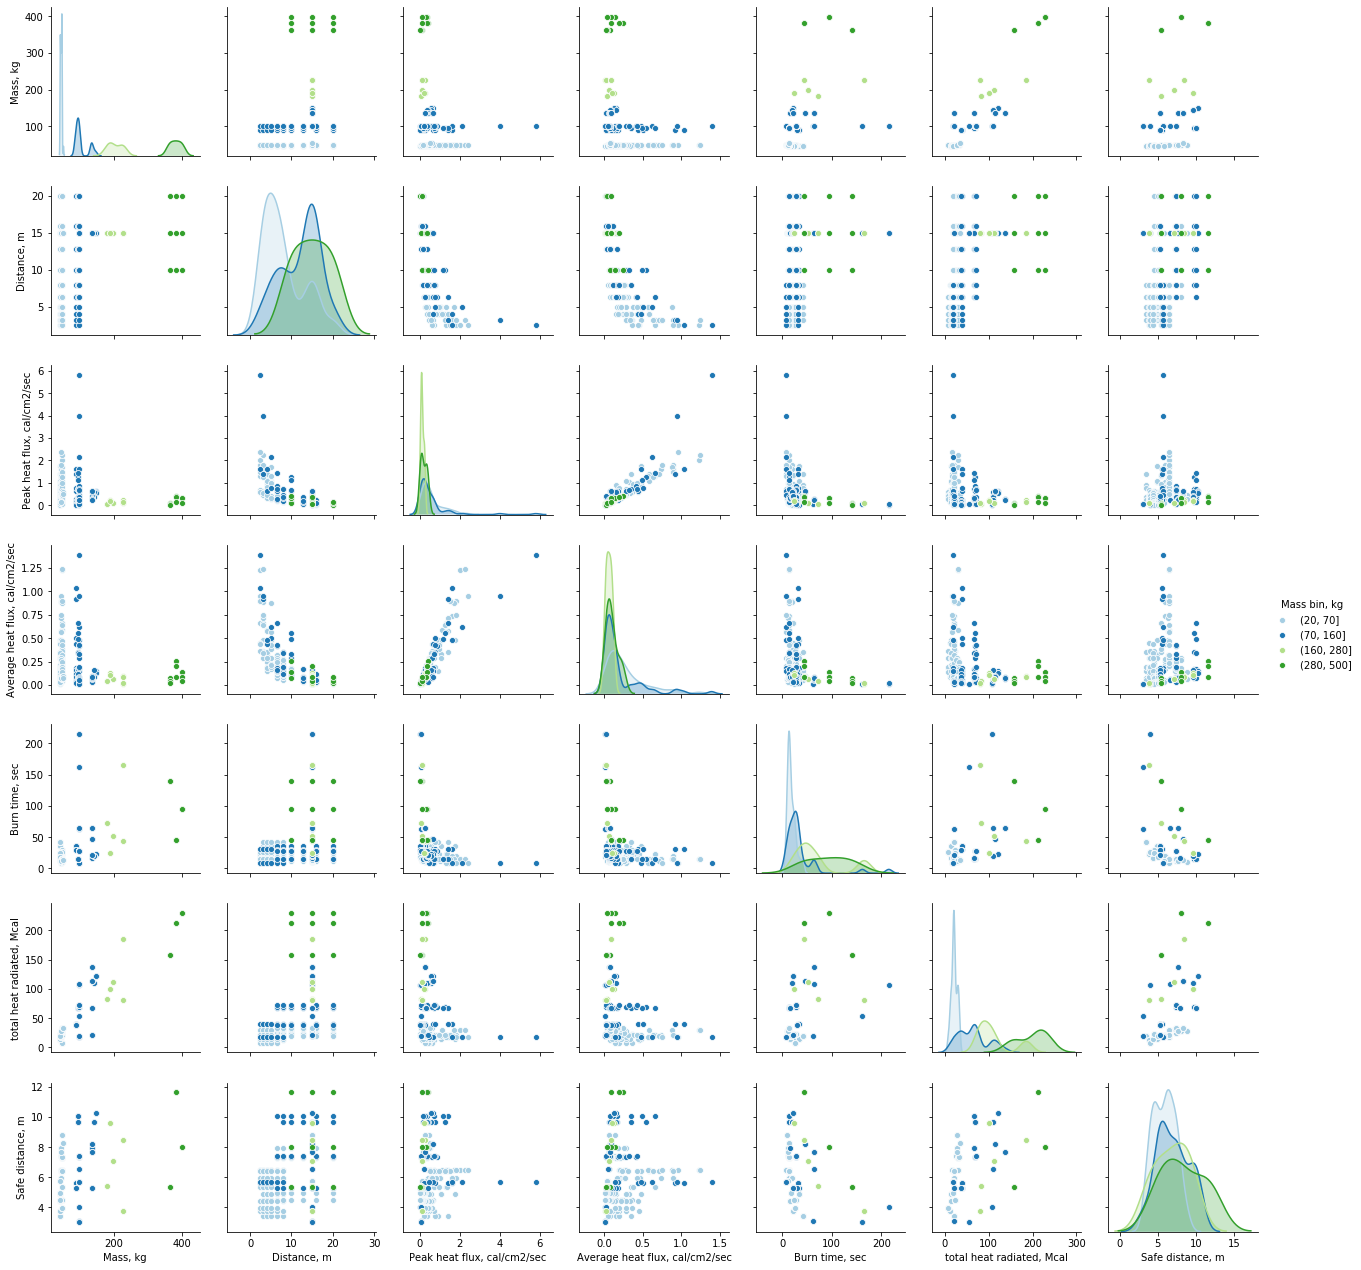

In [16]:
sea.pairplot(dfsub, hue="Mass bin, kg")

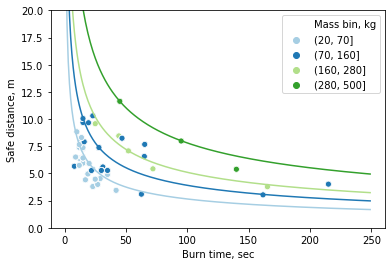

In [17]:
sea.scatterplot(df['Burn time, sec'],df['Safe distance, m'],hue=df['Mass bin, kg'])
for fact in factor:
    x = np.arange(1,250); y=fact/x**0.5
    plt.plot(x,y)
plt.ylim([0,20])
plt.show()

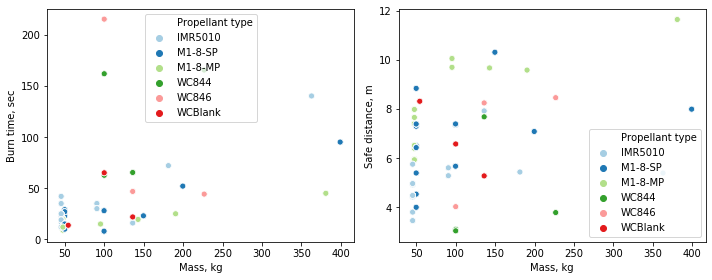

In [18]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
sea.scatterplot(df['Mass, kg'],df['Burn time, sec'],hue=df['Propellant type'],ax=ax[0])
sea.scatterplot(df['Mass, kg'],df['Safe distance, m'],hue=df['Propellant type'],ax=ax[1])
plt.tight_layout()
plt.show()